In [13]:
# https://www.packtpub.com/mapt/book/big_data_and_business_intelligence/9781787282773/3/ch03lvl1sec29/deeper-cnn

In [1]:
import tensorflow as tf
import numpy as np
import math

In [2]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

In [3]:
# Set random seed
np.random.seed(0)

In [5]:
# Load data
data = np.load('data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']

In [6]:
# Look at some data
print(train[0])
print(labels[0])

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0


In [7]:
# If you have matplotlib installed
import matplotlib.pyplot as plt
plt.ion()

In [8]:
def to_onehot(labels,nclasses = 5):
    '''
    Convert labels to "one-hot" format.
    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[ 1.,  0.,  0.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.],
           [ 0.,  0.,  1.,  0.,  0.],
           [ 0.,  0.,  0.,  1.,  0.]])
    '''
    outlabels = np.zeros((len(labels),nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

In [9]:
onehot = to_onehot(labels)

In [10]:
# Split data into training and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt],\
                         indices[valid_cnt:]
test, train = train[test_idx,:],\
              train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:],\
                        onehot[training_idx,:]

In [11]:
sess = tf.InteractiveSession()

In [12]:
# These will be inputs
## Input pixels, image with one channel (gray)
x = tf.placeholder("float", [None, 36, 36])
# Note that -1 is for reshaping
x_im = tf.reshape(x, [-1,36,36,1])
## Known labels
# None works during variable creation to be
# unspecified size
y_ = tf.placeholder("float", [None,5])

In [14]:
# Conv layer 1
num_filters1 = 16
winx1 = 3
winy1 = 3
W1 = tf.Variable(tf.truncated_normal(
    [winx1, winy1, 1 , num_filters1],
    stddev=1./math.sqrt(winx1*winy1)))
b1 = tf.Variable(tf.constant(0.1,
                shape=[num_filters1]))
# 5x5 convolution, pad with zeros on edges
xw = tf.nn.conv2d(x_im, W1,
                  strides=[1, 1, 1, 1],
                  padding='SAME')
h1 = tf.nn.relu(xw + b1)
# 2x2 Max pooling, no padding on edges
p1 = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1], padding='VALID')

In [15]:
# Conv layer 2
num_filters2 = 4
winx2 = 3
winy2 = 3
W2 = tf.Variable(tf.truncated_normal(
    [winx2, winy2, num_filters1, num_filters2],
    stddev=1./math.sqrt(winx2*winy2)))
b2 = tf.Variable(tf.constant(0.1,
     shape=[num_filters2]))
# 3x3 convolution, pad with zeros on edges
p1w2 = tf.nn.conv2d(p1, W2,
       strides=[1, 1, 1, 1], padding='SAME')
h1 = tf.nn.relu(p1w2 + b2)
# 2x2 Max pooling, no padding on edges
p2 = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1],
     strides=[1, 2, 2, 1], padding='VALID')

In [16]:
# Need to flatten convolutional output
p2_size = np.product(
        [s.value for s in p2.get_shape()[1:]])
p2f = tf.reshape(p2, [-1, p2_size ])

In [17]:
# Dense layer
num_hidden = 32
W3 = tf.Variable(tf.truncated_normal(
     [p2_size, num_hidden],
     stddev=2./math.sqrt(p2_size)))
b3 = tf.Variable(tf.constant(0.2,
     shape=[num_hidden]))
h3 = tf.nn.relu(tf.matmul(p2f,W3) + b3)

In [18]:
# Drop out training
keep_prob = tf.placeholder("float")
h3_drop = tf.nn.dropout(h3, keep_prob)

In [19]:
# Output Layer
W4 = tf.Variable(tf.truncated_normal(
     [num_hidden, 5],
     stddev=1./math.sqrt(num_hidden)))
b4 = tf.Variable(tf.constant(0.1,shape=[5]))

In [21]:
# Just initialize
sess.run(tf.global_variables_initializer())

In [22]:
# Define model
y = tf.nn.softmax(tf.matmul(h3_drop,W4) + b4)

### End model specification, begin training code


In [23]:
# Climb on cross-entropy
cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
        logits = y + 1e-50, labels = y_))

In [24]:
# How we train
train_step = tf.train.GradientDescentOptimizer(
             0.01).minimize(cross_entropy)

In [25]:
# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1),
                              tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(
           correct_prediction, "float"))

In [28]:
# Actually train
epochs = 10
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs), ascii=True):
    # Record summary data, and the accuracy
    if i % 10 == 0:  
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x: train,
            y_: onehot_train, keep_prob: 1.0})
        train_acc[i//10] = A
        # And now the validation set
        A = accuracy.eval(feed_dict={x: test,
            y_: onehot_test, keep_prob: 1.0})
        test_acc[i//10] = A
    train_step.run(feed_dict={x: train,\
        y_: onehot_train, keep_prob: 0.5})

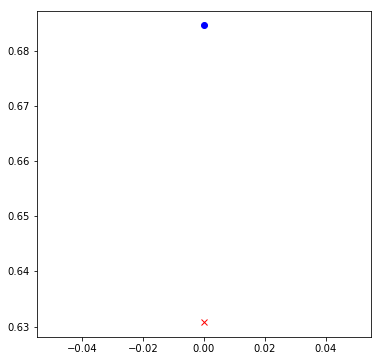

In [29]:
# Plot the accuracy curves
plt.figure(figsize=(6, 6))
plt.plot(train_acc,'bo')
plt.plot(test_acc,'rx')

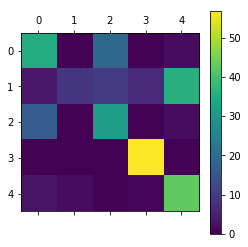

In [30]:
# Look at the final testing confusion matrix
pred = np.argmax(y.eval(
       feed_dict={x: test, keep_prob: 1.0,
       y_: onehot_test}), axis = 1)
conf = np.zeros([5,5])
for p,t in zip(pred,np.argmax(onehot_test,
                              axis=1)):
    conf[t,p] += 1

plt.matshow(conf)
plt.colorbar()

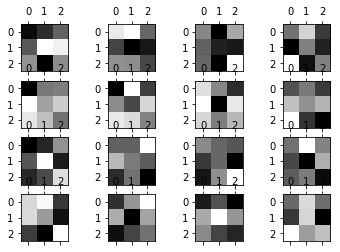

In [31]:
# Let's look at a subplot of some weights
f, plts = plt.subplots(4,4)
for i in range(16):
    plts[i//4,i%4].matshow(W1.eval()[:,:,0,i],
            cmap = plt.cm.gray_r)

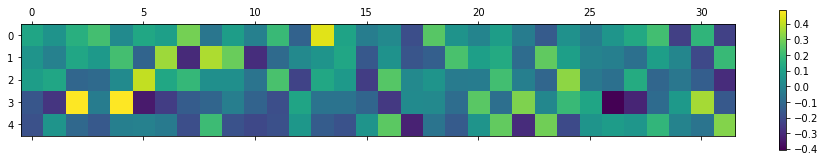

In [32]:
# Examine the output weights
plt.matshow(W4.eval().T)
plt.colorbar()

In [33]:
# Save the weights
saver = tf.train.Saver()
saver.save(sess, "conv2a.ckpt")

'conv2a.ckpt'

In [34]:
# Restore
saver.restore(sess, "conv2a.ckpt")

INFO:tensorflow:Restoring parameters from conv2a.ckpt
